### Dataset

In [88]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam, AdamW, Nadam, RMSprop, SGD
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skopt import BayesSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from keras.losses import categorical_crossentropy
from sklearn.metrics import log_loss
from keras.utils import to_categorical
from adabound import AdaBound
from tensorflow.keras.metrics import AUC

In [89]:
# Evito que ciertas columnas se transformen a notacion cientifica en las predicciones
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

In [90]:
columns = [
    'Open_time',
    'Open',
    'High',
    'Low',
    # 'Close',
    'Number of trades',
    'Close_BTCUSDT',
    'Volume_BTCUSDT',
    'Number_of_trades_BTCUSDT',
    'Close_ETHUSDT',
    'Volume_ETHUSDT',
    'Number_of_trades_ETHUSDT',
    'Close_BNBUSDT',
    'Volume_BNBUSDT',
    'Number_of_trades_BNBUSDT',
    'SMA_20',
    'EMA_20',
    'Upper_Band',
    'Middle_Band',
    'Lower_Band',
    'RSI',
    'buy_1000x_high_coinbase',
    'sell_1000x_high_coinbase',
    'total_trades_coinbase',	
    'Tweets_Utilizados',
    'Tweets_Utilizados_coin',
    'Tweets_Utilizados_referentes',
    'Tweets_Utilizados_whale_alert',
    'Buy_1000x_high',
    'sell_1000x_high',
    'total_trades_binance'
]

### Armado y entrenamiento de un clasificador a partir de los datos originales

#### Modelo LSTM

In [91]:
complete_dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv') 
classifier_dataset = complete_dataset[columns]
classifier_dataset['Open_time'] = pd.to_datetime(classifier_dataset['Open_time'])
classifier_dataset['Tendencia'] = complete_dataset['Tendencia']

clasifier_validation = classifier_dataset[-10:]
classifier_dataset = classifier_dataset[:-10]

In [92]:
display(classifier_dataset.tail())

,Open_time,Open,High,Low,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
941,2024-04-25,6.93,7.00,6.70,71088.00,64498.34,31341.46,1375324.00,3155.80,352288.55,861077.00,613.20,453745.52,353114.00,7.43,7.45,9.08,7.43,5.77,38.83,21.00,26.00,33468.00,151,114,0.00,22.00,242.00,219.00,48000.00,Lateral
942,2024-04-26,6.86,6.95,6.71,67383.00,63770.01,27085.19,1025561.00,3131.30,252522.65,628635.00,598.00,302119.88,269508.00,7.34,7.38,8.94,7.34,5.74,37.81,29.00,24.00,26619.00,117,106,0.00,14.00,292.00,324.00,42000.00,Lateral
943,2024-04-27,6.76,6.87,6.51,64779.00,63461.98,20933.06,912422.00,3255.56,323811.19,734026.00,596.20,268783.91,233820.00,7.24,7.33,8.73,7.24,5.76,38.57,17.00,17.00,25565.00,101,138,0.00,7.00,248.00,179.00,41000.00,Lateral
944,2024-04-28,6.81,6.95,6.69,43208.00,63118.62,16949.20,790652.00,3263.45,304766.01,753239.00,600.20,258059.43,206703.00,7.13,7.27,8.38,7.13,5.88,37.66,16.00,20.00,20954.00,82,106,0.00,13.00,173.00,165.00,26000.00,Lateral
945,2024-04-29,6.73,6.83,6.47,63006.00,63866.00,28150.23,1152296.00,3216.73,421831.29,943719.00,592.80,330474.01,271926.00,7.03,7.20,8.08,7.03,5.97,36.02,69.00,37.00,33959.00,115,125,0.00,24.00,260.00,188.00,41000.00,Bajista


In [93]:
classifier_dataset.shape

(946, 31)

In [94]:
X = classifier_dataset.drop(columns=["Tendencia", "Open_time"])
y = classifier_dataset["Tendencia"]

y = y.to_numpy().reshape(-1, 1)
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot = onehot_encoder.fit_transform(y)


In [95]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_validation = clasifier_validation.drop(columns=["Tendencia", "Open_time"])
y_validation = clasifier_validation["Tendencia"]

X_validation_scaled = scaler.transform(X_validation)
y_validation = y_validation.to_numpy().reshape(-1, 1)
y_validation_one_hot = onehot_encoder.transform(y_validation)

In [96]:
display(X_scaled)

array([[ 1.71028637,  1.73812395,  1.71239905, ...,  0.62105604,
         0.07813715,  1.10706827],
       [ 1.60086133,  1.5617387 ,  1.57244477, ...,  0.41483393,
        -0.04949395,  0.6669114 ],
       [ 1.46310302,  1.58144131,  1.56935754, ...,  0.88953389,
         0.58479392,  0.74693992],
       ...,
       [-0.44646164, -0.45674653, -0.44752767, ..., -0.45674632,
        -0.6373705 , -0.42014269],
       [-0.4422605 , -0.44877167, -0.42910722, ..., -0.74857006,
        -0.69151703, -0.52017834],
       [-0.45027198, -0.46049941, -0.45174688, ..., -0.41005452,
        -0.60256202, -0.42014269]])

In [97]:
display(y_one_hot)

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [98]:
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Bidirectional


def create_model(activation, units, dropout, learning_rate, l2_penalty, depth, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=int(units/2), activation=activation, input_shape=(len(X.columns), 1), return_sequences=True, kernel_regularizer=l2(l2_penalty)))
    # model.add(Bidirectional(LSTM(units=int(units/2), activation=activation, return_sequences=True, input_shape=(len(X.columns), 1), kernel_regularizer=l2(l2_penalty))))

    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    for _ in range(depth - 1):
        # model.add(Bidirectional(LSTM(units=units, activation=activation, return_sequences=True, kernel_regularizer=l2(l2_penalty))))
        model.add(LSTM(units=units, activation=activation, return_sequences=True, kernel_regularizer=l2(l2_penalty)))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    
    # model.add(Bidirectional(LSTM(units=int(units*2), activation=activation, kernel_regularizer=l2(l2_penalty))))
    model.add(LSTM(units=int(units*2), activation=activation, kernel_regularizer=l2(l2_penalty)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(units=3, activation='softmax'))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    # elif optimizer == 'adamw':
    #     optimizer = AdamW(learning_rate=learning_rate)
    # elif optimizer == 'nadam':
    #     optimizer = Nadam(learning_rate=learning_rate)
    # elif optimizer == 'adabound':
    #     optimizer = AdaBound(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[AUC(name='auc')])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
classifier = KerasClassifier(build_fn=create_model, verbose=0, activation='relu', units=50, dropout=0.2, learning_rate=0.1, l2_penalty=0.001, depth=2, optimizer='adam')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

cv = TimeSeriesSplit(n_splits=10)

param_space = {
    'depth': [2, 3, 4, 5, 6],
    'activation': ['relu', 'tanh', 'swish', 'selu'],
    'units': [64, 128, 256, 512],
    'dropout': [0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [10, 20, 30, 50, 100],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    # 'optimizer': ['adam', 'adamw', 'nadam', 'adabound'],
    'l2_penalty': [0.001, 0.01, 0.1]
}

def categorical_crossentropy_loss(estimator, X_test, y_test):
    y_pred = estimator.predict_proba(X_test)
    if np.isnan(y_pred).any():
        y_pred[np.isnan(y_pred)] = 0
    loss = log_loss(y_test, y_pred)
    return loss

bayes_search = BayesSearchCV(classifier, param_space, scoring=categorical_crossentropy_loss, cv=cv, verbose=0)#10)
# bayes_result = bayes_search.fit(X, y_one_hot, callbacks=[early_stopping, reduce_lr], shuffle=False, validation_split=0.1)
bayes_result = bayes_search.fit(X_scaled, y_one_hot, callbacks=[early_stopping, reduce_lr])

In [ ]:
# Show best results
print("Best score:", bayes_result.best_score_)
print("Best parameters:", bayes_result.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_model = bayes_result.best_estimator_
# best_model.fit(X, y_one_hot)
best_model.fit(X_scaled, y_one_hot)

Best score: 3.414628018367741
Best parameters: OrderedDict([('activation', 'swish'), ('batch_size', 128), ('depth', 5), ('dropout', 0.4), ('epochs', 30), ('l2_penalty', 0.01), ('learning_rate', 0.001), ('optimizer', 'adam'), ('units', 512)])


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7fb6b8dc0670>
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=30
	activation=swish
	units=512
	dropout=0.4
	learning_rate=0.001
	l2_penalty=0.01
	depth=5
	class_weight=None
)

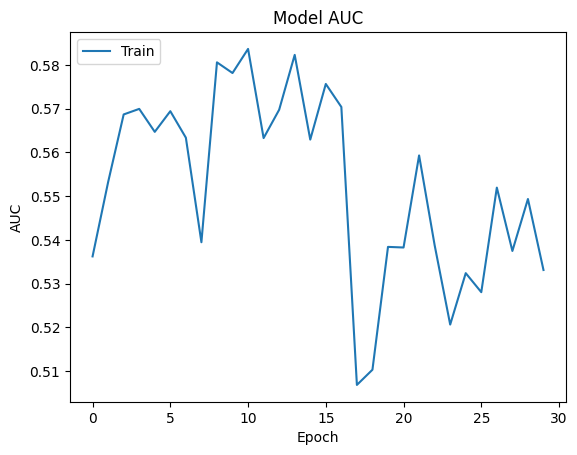

In [ ]:
import matplotlib.pyplot as plt

history = bayes_result.best_estimator_.model_.history

plt.plot(history.history['auc'])
# plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import json

# Obtener los hiperparámetros y puntajes de los 5 mejores modelos
top_n_models = 5
best_params_list = []
best_scores_list = []

if 'rank_test_score' in bayes_search.cv_results_:
    sorted_indices = np.argsort(bayes_search.cv_results_['rank_test_score'])

    for i in range(min(top_n_models, len(sorted_indices))):
        best_params_list.append(bayes_search.cv_results_['params'][sorted_indices[i]])
        best_scores_list.append(bayes_search.cv_results_['mean_test_score'][sorted_indices[i]])

    # Guardar los hiperparámetros de los 5 mejores modelos en un archivo JSON
    with open('conv_classifier/top_5_hyperparameters.json', 'w') as f:
        json.dump({'best_params': best_params_list, 'best_scores': best_scores_list}, f)

    # O imprimir los hiperparámetros
    print("Top 5 mejores modelos:")
    for i in range(len(best_params_list)):
        print("Modelo", i + 1)
        print("Hiperparámetros:", best_params_list[i])
        print("Puntaje:", best_scores_list[i])

else:
    print("Error: 'rank_test_score' no encontrado en cv_results_")


Top 5 mejores modelos:
Modelo 1
Hiperparámetros: OrderedDict([('activation', 'swish'), ('batch_size', 128), ('depth', 5), ('dropout', 0.4), ('epochs', 30), ('l2_penalty', 0.01), ('learning_rate', 0.001), ('optimizer', 'adam'), ('units', 512)])
Puntaje: 3.414628018367741
Modelo 2
Hiperparámetros: OrderedDict([('activation', 'relu'), ('batch_size', 128), ('depth', 5), ('dropout', 0.4), ('epochs', 100), ('l2_penalty', 0.001), ('learning_rate', 0.001), ('optimizer', 'adam'), ('units', 512)])
Puntaje: 2.8855634764522664
Modelo 3
Hiperparámetros: OrderedDict([('activation', 'swish'), ('batch_size', 128), ('depth', 5), ('dropout', 0.3), ('epochs', 30), ('l2_penalty', 0.001), ('learning_rate', 0.001), ('optimizer', 'adam'), ('units', 512)])
Puntaje: 2.874581274009606
Modelo 4
Hiperparámetros: OrderedDict([('activation', 'relu'), ('batch_size', 32), ('depth', 4), ('dropout', 0.4), ('epochs', 100), ('l2_penalty', 0.01), ('learning_rate', 0.001), ('optimizer', 'adam'), ('units', 512)])
Puntaje: 2

#### Armado del ensamble

In [ ]:
def generate_prime_seeds(n):
    seeds = []
    num = 70001  # Comenzamos desde el primer número primo mayor que 70000
    while len(seeds) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            seeds.append(num)
        num += 1
    return seeds


In [ ]:
## Clase personalizada para hacer el ensamble, dado que sklearn no provee ninguna clase que permita hacer ensmble
## de modelos re regresion multivariados
class MultivariableVotingClassifier:
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        # Hacer predicciones con cada modelo
        predictions = np.array([model.predict(X) for model in self.models])
        
        # Calcular la moda de las predicciones
        mode_predictions = np.argmax(np.sum(predictions, axis=0), axis=1)
        
        return mode_predictions


In [ ]:

import json

# Leer los hiperparámetros desde el archivo JSON
with open('lstm_classifier/top_5_hyperparameters.json', 'r') as f:
    top_hyperparameters = json.load(f)

prime_seeds = generate_prime_seeds(10)
models = []
best_seeds= {}

# Train models with different seeds for each set of hyperparameters
for mode_number, params in enumerate(top_hyperparameters['best_params']):
    best_validation_errors = {}
    
    for seed_number, seed in enumerate(prime_seeds):
        model = KerasClassifier(build_fn=create_model, random_state=seed, verbose=1, **params)
        # model.fit(X, y_one_hot)
        model.fit(X_scaled, y_one_hot)
        
        # Make predictions with the model
        # train_error = categorical_crossentropy_loss(model, X, y_one_hot)
        train_error = categorical_crossentropy_loss(model, X_scaled, y_one_hot)
        
        mean_train_error = np.mean(train_error)

        # Update best validation error for this seed
        best_validation_errors[seed] = mean_train_error
    
        print(f"model number {mode_number}, seed number {seed_number}")

    # Find the best seed for this set of hyperparameters
    best_seed_for_params = min(best_validation_errors, key=lambda k: best_validation_errors[k])
    best_seeds[str(params)] = best_seed_for_params
    
    # Create and train the model with the best seed
    model = KerasClassifier(build_fn=create_model, random_state=best_seed_for_params, verbose=0, **params)
    # model.fit(X, y_one_hot)
    model.fit(X_scaled, y_one_hot)
    models.append(model)

# Define and train the ensemble model
ensemble = MultivariableVotingClassifier(models)
# ensemble.fit(X, y_one_hot)
ensemble.fit(X_scaled, y_one_hot)

# Save the best seeds to a JSON file
with open('lstm_classifier/best_seeds.json', 'w') as f:
    json.dump(best_seeds, f)    

30/30 [==============================] - 31s 1s/step - loss: 49.1620 - auc: 0.5204
Epoch 9/10
30/30 [==============================] - 27s 888ms/step - loss: 49.1465 - auc: 0.5093
Epoch 10/10
30/30 [==============================] - 11s 327ms/step
model number 1, seed number 4
Epoch 1/10
30/30 [==============================] - 38s 922ms/step - loss: 11.8519 - auc: 0.4957
Epoch 2/10
30/30 [==============================] - 28s 923ms/step - loss: 17.3316 - auc: 0.4976
Epoch 3/10
30/30 [==============================] - 28s 947ms/step - loss: 17.8689 - auc: 0.4715
Epoch 4/10
30/30 [==============================] - 28s 919ms/step - loss: 19.4467 - auc: 0.5259
Epoch 5/10
30/30 [==============================] - 29s 974ms/step - loss: 19.3319 - auc: 0.5014
Epoch 6/10
30/30 [==============================] - 27s 909ms/step - loss: 18.5878 - auc: 0.5320
Epoch 7/10
30/30 [==============================] - 27s 910ms/step - loss: 17.9062 - auc: 0.5099
Epoch 8/10
30/30 [=========================

#### Clasificacion con el ensamble sobre las redicciones de los modelos generativos

In [ ]:
with open('lstm_classifier/best_seeds.json', 'r') as f:
    best_seeds = json.load(f)

# 21 Crear y entrenar los modelos con los hiperparámetros y semillas guardados
models = []
for params_str, seed in best_seeds.items():
    params = json.loads(params_str.replace("'", "\""))
    model = KerasClassifier(build_fn=create_model, random_state=seed, **params)
    # model.fit(X, y_one_hot)
    model.fit(X_scaled, y_one_hot)
    models.append(model)

Epoch 1/100
30/30 [==============================] - 21s 509ms/step - loss: 6.9095 - auc: 0.5153
Epoch 2/100
30/30 [==============================] - 16s 520ms/step - loss: 10.4837 - auc: 0.4896
Epoch 3/100
30/30 [==============================] - 16s 517ms/step - loss: 10.1228 - auc: 0.5171
Epoch 4/100
30/30 [==============================] - 16s 533ms/step - loss: 9.6358 - auc: 0.5131
Epoch 5/100
30/30 [==============================] - 16s 528ms/step - loss: 9.4575 - auc: 0.4934
Epoch 6/100
30/30 [==============================] - 15s 516ms/step - loss: 9.8927 - auc: 0.4920
Epoch 7/100
30/30 [==============================] - 16s 522ms/step - loss: 9.6661 - auc: 0.5210
Epoch 8/100
30/30 [==============================] - 16s 526ms/step - loss: 9.4172 - auc: 0.5149
Epoch 9/100
30/30 [==============================] - 16s 523ms/step - loss: 9.1278 - auc: 0.5158
Epoch 10/100
30/30 [==============================] - 16s 525ms/step - loss: 8.7828 - auc: 0.5190
Epoch 11/100
30/30 [=======

In [ ]:
ensemble = MultivariableVotingClassifier(models)
# ensemble.fit(X, y_one_hot)
ensemble.fit(X_scaled, y_one_hot)

8/8 [==============================] - 14s 2s/step - loss: 15.2684 - auc: 0.4987
Epoch 12/100
8/8 [==============================] - 13s 2s/step - loss: 14.7175 - auc: 0.5093
Epoch 13/100
8/8 [==============================] - 11s 1s/step - loss: 14.2637 - auc: 0.4751
Epoch 14/100
8/8 [==============================] - 11s 1s/step - loss: 14.0593 - auc: 0.5115
Epoch 15/100
8/8 [==============================] - 11s 1s/step - loss: 14.1739 - auc: 0.5256
Epoch 16/100
8/8 [==============================] - 11s 1s/step - loss: 14.1539 - auc: 0.4876
Epoch 17/100
8/8 [==============================] - 11s 1s/step - loss: 13.9089 - auc: 0.5168
Epoch 18/100
8/8 [==============================] - 11s 1s/step - loss: 13.6585 - auc: 0.4815
Epoch 19/100
8/8 [==============================] - 11s 1s/step - loss: 13.3469 - auc: 0.5073
Epoch 20/100
8/8 [==============================] - 11s 1s/step - loss: 13.0968 - auc: 0.5025
Epoch 21/100
8/8 [==============================] - 11s 1s/step - loss: 1

##### Datos originales:

In [ ]:
display(clasifier_validation)

,Open_time,Open,High,Low,Number of trades,Close_BTCUSDT,Volume_BTCUSDT,Number_of_trades_BTCUSDT,Close_ETHUSDT,Volume_ETHUSDT,Number_of_trades_ETHUSDT,Close_BNBUSDT,Volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Tweets_Utilizados,Tweets_Utilizados_coin,Tweets_Utilizados_referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
946,2024-04-30,6.59,6.67,6.04,115512.00,60672.00,54947.66,1985671.00,3014.05,561717.49,1292873.00,578.40,766513.45,486465.00,6.93,7.13,7.80,6.93,6.05,34.18,51.00,55.00,48709.00,142,187,1.00,23.00,379.00,377.00,70000.00,Bajista
947,2024-05-01,6.42,6.93,6.13,175570.00,58364.97,81166.47,2401089.00,2972.46,624963.78,1365039.00,561.80,669027.32,427425.00,6.85,7.11,7.41,6.85,6.29,43.30,42.00,50.00,83718.00,130,177,0.00,36.00,327.00,340.00,107000.00,Alcista
948,2024-05-02,6.90,7.41,6.69,109002.00,59060.61,47583.82,1572898.00,2986.19,365939.72,880167.00,560.50,359794.32,250921.00,6.85,7.12,7.42,6.85,6.29,49.27,87.00,57.00,61208.00,461,374,1.00,25.00,270.00,282.00,71000.00,Alcista
949,2024-05-03,7.27,7.39,7.00,109634.00,62882.01,43628.40,1558661.00,3102.61,355825.84,859542.00,587.00,342906.43,257575.00,6.90,7.14,7.44,6.90,6.35,48.86,52.00,40.00,46255.00,573,474,1.00,22.00,386.00,635.00,69000.00,Lateral
950,2024-05-04,7.24,7.28,7.11,71120.00,63892.04,24368.69,1113509.00,3117.23,196263.95,575026.00,585.70,197129.25,210303.00,6.91,7.13,7.46,6.91,6.36,46.98,68.00,50.00,34251.00,407,472,0.00,14.00,203.00,232.00,49000.00,Bajista
951,2024-05-05,7.12,7.40,7.01,72928.00,64012.00,18526.75,992921.00,3136.41,218760.27,600693.00,592.00,180458.24,180794.00,6.94,7.15,7.51,6.94,6.37,50.00,37.00,52.00,29197.00,417,499,0.00,6.00,320.00,284.00,47000.00,Alcista
952,2024-05-06,7.30,7.47,7.06,94264.00,63165.19,34674.92,1392557.00,3062.60,355135.30,873200.00,588.20,278669.01,248490.00,6.96,7.15,7.53,6.96,6.39,47.10,49.00,71.00,40027.00,482,531,0.00,25.00,339.00,249.00,59000.00,Bajista
953,2024-05-07,7.12,7.29,6.98,64947.00,62312.08,25598.79,1272898.00,3005.69,298796.68,815246.00,576.50,289488.71,266127.00,6.98,7.13,7.52,6.98,6.44,45.10,21.00,25.00,31028.00,495,494,0.00,28.00,296.00,205.00,42000.00,Bajista
954,2024-05-08,6.99,7.19,6.89,75550.00,61193.03,26121.19,1415152.00,2974.21,266934.81,830635.00,588.60,297016.62,249379.00,6.99,7.12,7.52,6.99,6.46,44.94,17.00,24.00,32040.00,426,494,0.00,24.00,230.00,177.00,49000.00,Lateral
955,2024-05-09,6.98,7.09,6.78,75016.00,63074.01,30660.81,1381957.00,3036.23,238561.75,686147.00,596.80,464857.60,332988.00,7.01,7.11,7.52,7.01,6.50,46.32,18.00,17.00,29314.00,475,464,0.00,16.00,188.00,257.00,50000.00,Lateral


In [ ]:
n_clases = 3 

clasifier_validation = clasifier_validation[columns]
validation_predictions = ensemble.predict(clasifier_validation.drop(columns=["Open_time"]))
predicciones_one_hot = to_categorical(validation_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(validation_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 164ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista']

##### Datos generados por auto ml con prophet:

In [ ]:
auto_ml_prophet_df = pd.read_csv('auto_timeseries_models_prophet/predicciones.csv')
auto_ml_prophet_df = auto_ml_prophet_df[columns]
auto_mp_prophet_predictions = ensemble.predict(auto_ml_prophet_df.drop(columns=["Open_time"]))

predicciones_one_hot = to_categorical(auto_mp_prophet_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(auto_mp_prophet_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 139ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista']

##### Datos generados por auto ml con stats:

In [ ]:
auto_ml_stats_df = pd.read_csv('auto_timeseries_models/predicciones.csv')
auto_ml_stats_df = auto_ml_stats_df[columns]
auto_mp_stats_predictions = ensemble.predict(auto_ml_stats_df.drop(columns=["Open_time"]))

predicciones_one_hot = to_categorical(auto_mp_stats_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(auto_mp_stats_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 152ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista']

##### Datos generados por auto ml con modelos clasicos:

In [ ]:
auto_ml_df = pd.read_csv('h2o_models/predicciones.csv')
auto_ml_df = auto_ml_df[columns]
auto_mp_predictions = ensemble.predict(auto_ml_df.drop(columns=["Open_time"]))

predicciones_one_hot = to_categorical(auto_mp_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(auto_mp_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 149ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista']

##### Datos generados por auto ml con skforecast

In [ ]:
skforecast_df = pd.read_csv('skforecast/predicciones.csv')
skforecast_df = skforecast_df[columns[1:]]
skforecast_predictions = ensemble.predict(skforecast_df)

predicciones_one_hot = to_categorical(skforecast_predictions, num_classes=n_clases)
etiquetas_numericas = np.argmax(predicciones_one_hot, axis=1)
categorias_clases = onehot_encoder.categories_[0]
nombres_clases = [categorias_clases[indice] for indice in etiquetas_numericas]

display(skforecast_predictions)
display(categorias_clases)
display(nombres_clases)

1/1 [==============================] - 0s 294ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array(['Alcista', 'Bajista', 'Lateral'], dtype=object)

['Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista',
 'Alcista']

### Analizo los features mas importantes

In [ ]:
# import shap
# from sklearn.inspection import permutation_importance

# feature_importances = pd.DataFrame()

# model = models[0]
# # Assuming X_test and y_test are your test data
# X_test = X  # Replace with your actual test data
# y_test = y_one_hot  # Replace with your actual test labels

# perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
# feature_importances[f'model_{i}'] = perm_importance.importances_mean

# # Calculate the mean importance across all models
# feature_importances['mean_importance'] = feature_importances.mean(axis=1)

# print(feature_importances)

# # Optional: Use SHAP for additional interpretation (example for a Keras model)
# explainer = shap.Explainer(models[0], X_test)  # This can be resource-intensive
# shap_values = explainer(X_test)
# shap.summary_plot(shap_values, X_test)